* Yaromir Kapustin
* 16.11.2022
* v0.1

---
#### Проанализировать данные по выживаемости. 
- Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
- Определить наиболее значимые переменные которые влияют на выживаемость. 
- Визуализировать дерево решений. 
- Написать вывод. 
- Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("titanic_train.csv")
df_test = pd.read_csv("titanic_test.csv")

# Чистка датасета

In [3]:
#есть пропуски в колонках Age, Embarked, Cabin
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
#замена отсутствующих значений возраста медианным
df['Age'] = df['Age'].fillna(df['Age'].median())

In [5]:
#наиболее распостраненные значения пропущеных в колонке Embarked
imp = SimpleImputer(strategy='most_frequent')
df['Embarked'] = imp.fit_transform(df['Embarked'].values.reshape(-1,1))

In [6]:
#дубликатов нет
df.drop_duplicates()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
# 2/3 номеров билетов уникальны, так что признак малоинформативен
len(df.Ticket.unique())

681

In [8]:
#убираю колонку PassengerId, Ticket
df.drop('PassengerId', inplace=True, axis=1)
df.drop('Ticket', inplace=True, axis=1)

In [9]:
#чистка столбца имён
df.loc[df['Name'].str.contains('Mr.'), 'Name'] = 'Mr'
df.loc[df['Name'].str.contains('Miss.'), 'Name'] = 'Miss'
df.loc[df['Name'].str.contains('Ms.'), 'Name'] = 'Miss'
df.loc[df['Name'].str.contains('Mme.'), 'Name'] = 'Miss'
df.loc[df['Name'].str.contains('Mlle.'), 'Name'] = 'Miss'
df.loc[df['Name'].str.contains('Master.'), 'Name'] = 'Master'
df.loc[df['Name'].str.contains('Don.'), 'Name'] = 'Don'
df.loc[df['Name'].str.contains('Rev.'), 'Name'] = 'Rev'
df.loc[df['Name'].str.contains('Dr.'), 'Name'] = 'Dr'
df.loc[df['Name'].str.contains('Col.'), 'Name'] = 'Col'
df.loc[df['Name'].str.contains('Major.'), 'Name'] = 'Major'
df.loc[df['Name'].str.contains('Capt.'), 'Name'] = 'Capt'
df.loc[df['Name'].str.contains('Jonkheer.'), 'Name'] = 'Jonkheer'
df.loc[df['Name'].str.contains('Countess.'), 'Name'] = 'Countess'

In [10]:
df.Name.unique()

array(['Mr', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Major', 'Col', 'Capt',
       'Countess', 'Jonkheer'], dtype=object)

In [11]:
#чистка столбца кают
#поскольку большинство билетов имеют низкую цену, то логично предположить что каюты находились на палубе E 
#(F и G вероятно были грузовыми)
df['Cabin'] = df['Cabin'].fillna('E')

In [12]:
df.loc[df['Cabin'].str.contains('A'), 'Cabin'] = 'A'
df.loc[df['Cabin'].str.contains('B'), 'Cabin'] = 'B'
df.loc[df['Cabin'].str.contains('C'), 'Cabin'] = 'C'
df.loc[df['Cabin'].str.contains('D'), 'Cabin'] = 'D'
df.loc[df['Cabin'].str.contains('E'), 'Cabin'] = 'E'
df.loc[df['Cabin'].str.contains('F'), 'Cabin'] = 'F'
df.loc[df['Cabin'].str.contains('G'), 'Cabin'] = 'G'

df.Cabin.unique()

array(['E', 'C', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [51]:
# округляю возраст для корректного отображения графика
df['Age'] = df['Age'].round(decimals = -1)

In [52]:
#итоговый результат
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,Mr,male,20.0,1,0,7.2500,E,S
1,1,1,Mr,female,40.0,1,0,71.2833,C,C
2,1,3,Miss,female,30.0,0,0,7.9250,E,S
3,1,1,Mr,female,40.0,1,0,53.1000,C,S
4,0,3,Mr,male,40.0,0,0,8.0500,E,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,Rev,male,30.0,0,0,13.0000,E,S
887,1,1,Miss,female,20.0,0,0,30.0000,B,S
888,0,3,Miss,female,30.0,1,2,23.4500,E,S
889,1,1,Mr,male,30.0,0,0,30.0000,C,C


# Анализ данных

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

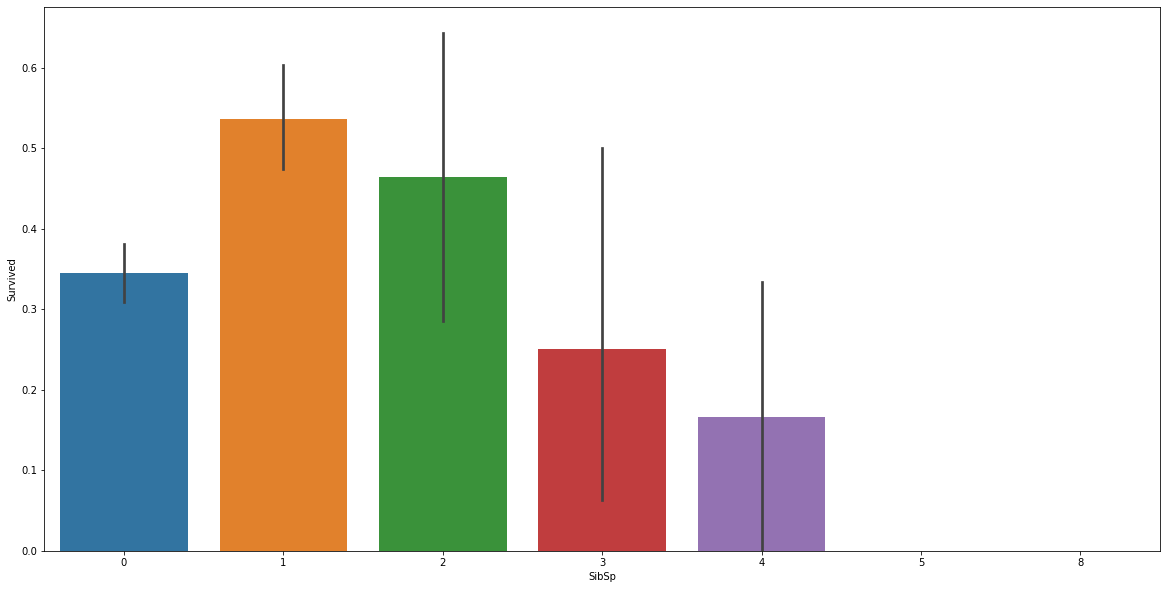

In [26]:
#SibSp — содержит информацию о количестве родственников 2-го порядка (муж, жена, братья, сетры)
plt.figure(figsize=(20,10))
sns.barplot(data=df, x="SibSp", y="Survived")

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

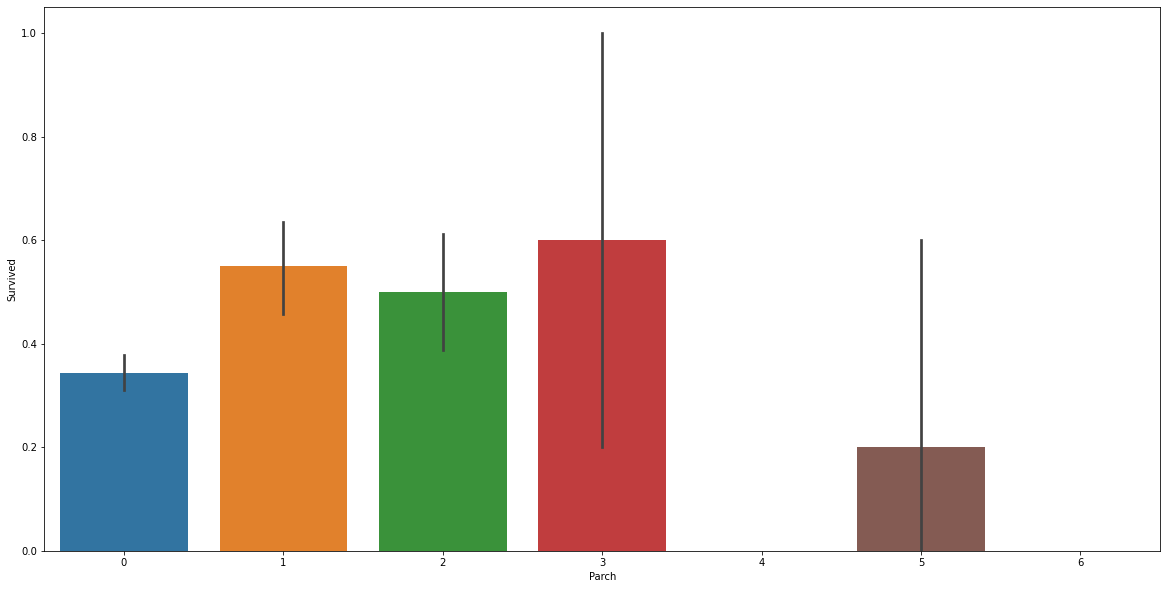

In [27]:
#Parch — содержит информацию о количестве родственников на борту 1-го порядка (мать, отец, дети)
plt.figure(figsize=(20,10))
sns.barplot(data=df, x="Parch", y="Survived")

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

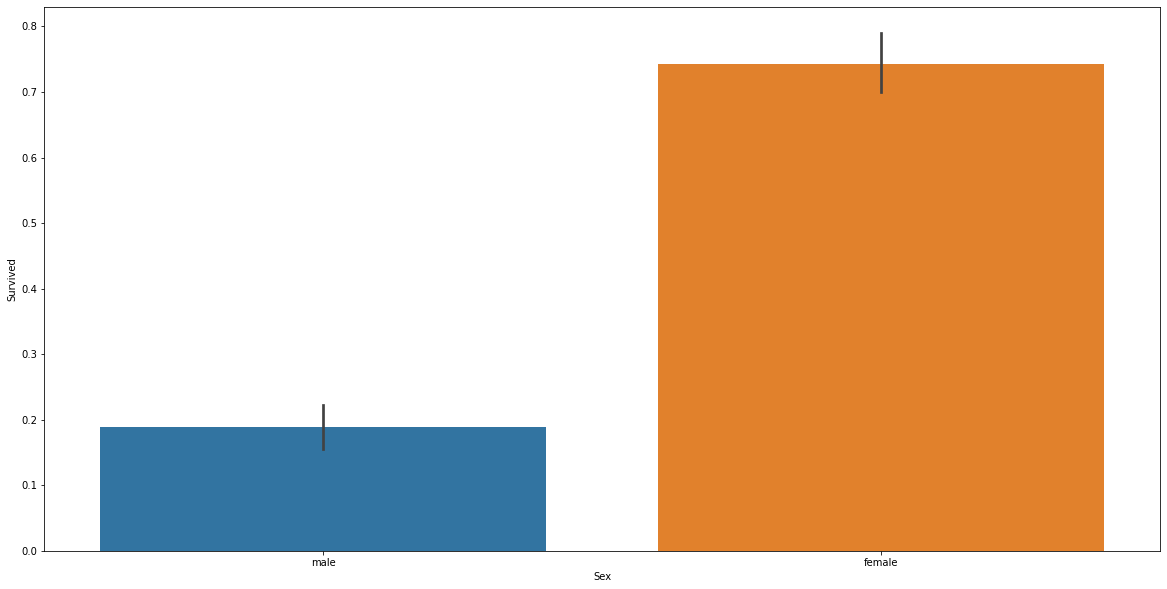

In [28]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x="Sex", y="Survived")

<AxesSubplot:xlabel='Age', ylabel='Survived'>

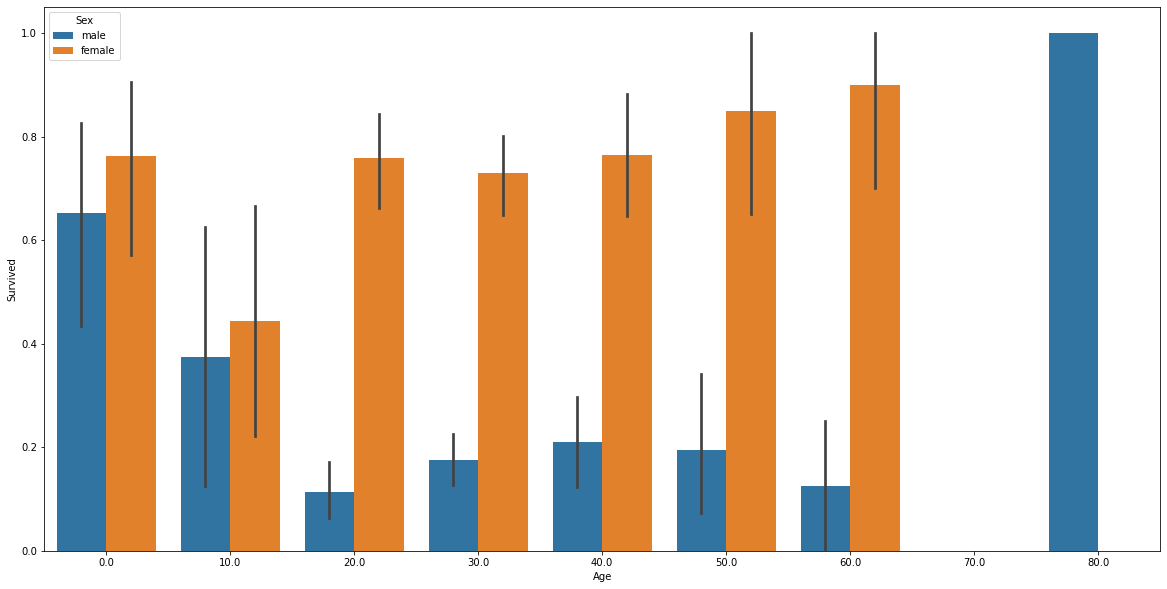

In [53]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x="Age", y="Survived", hue = "Sex")

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

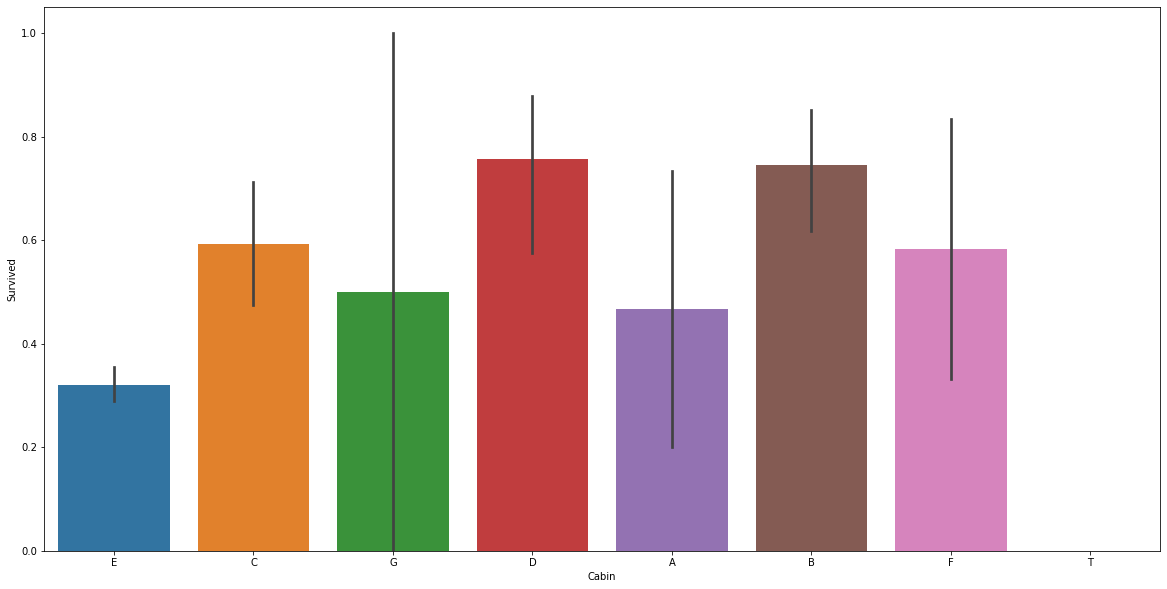

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x="Cabin", y="Survived")

### Ответы на поставленные вопросы
1. Как влияет размер семьи на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).

> Большая семья не увеличивает заметно шансы на выживаемость. Шанс выжить больше у кого 1-3 родственника 1 порядка (мать, отец, дети) и 1-2 родственника 2 порядка (муж, жена, братья, сетры).


2. Как влияет пол/возраст/номер палубы.

> Из выживжих 80% - женщины. Дети обоих полов имеют хорошую выживаемость. Начиная с совершеннолетия у женщин падает выживаемость до среднего возраста и возрастает к пенсионному (у мужчин наоборот). С номером палубы сложно говорить о какой-либо взаимосвязи.

## Подготовка модели RandomForestClassifier

In [53]:
#дамми-кодирование категориальных данных
df = pd.concat([df, 
                      pd.get_dummies(df['Name'], prefix="Name"),
                      pd.get_dummies(df['Sex'], prefix="Sex"),
                      pd.get_dummies(df['Cabin'], prefix="Cabin"),
                      pd.get_dummies(df['Embarked'], prefix="Embarked")],
                     axis=1)

df.drop(['Name','Sex','Cabin', 'Embarked'], axis=1, inplace=True)

In [54]:
X_train = df.drop(['Survived'], axis=1)
y_train = df['Survived']
df = pd.concat([X_train, y_train], axis=1)

In [95]:
rfc = RandomForestClassifier(max_depth = 11, max_features = 6)
rfc.fit(X_train, y_train)
roc_auc_score(y_train, rfc.predict_proba(X_train)[:, 1])

0.9825999424791486

In [56]:
#подбор гиперпараметров
params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring = 'accuracy', verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


C:\conda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\conda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\conda\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\conda\lib\site-packages\sklearn\tree\_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn(some_fits_failed_message, FitFail

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_depth': [10, 11, 12, 13, 14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy', verbose=1)

In [57]:
grid_search_cv.best_params_

{'max_depth': 11, 'max_features': 6}

### Оценка важности параметров
Наиболее важные признаки: цена билета, возраст, пол, наличие родственников

---

In [58]:
rfc.feature_importances_

array([9.13126540e-02, 1.50875168e-01, 5.93987659e-02, 3.69328631e-02,
       1.80545748e-01, 3.70370989e-04, 1.14501197e-03, 2.35480263e-05,
       2.68629455e-04, 1.57491215e-03, 2.92515259e-04, 1.45393802e-03,
       1.79696833e-02, 3.60920498e-02, 2.72232566e-02, 2.18554231e-03,
       1.33802291e-01, 1.69526391e-01, 3.50906738e-03, 7.18104739e-03,
       6.61499414e-03, 8.15737106e-03, 2.17032548e-02, 1.33388452e-03,
       1.54412819e-03, 1.11048196e-04, 1.36547458e-02, 1.04256969e-02,
       1.47714231e-02])

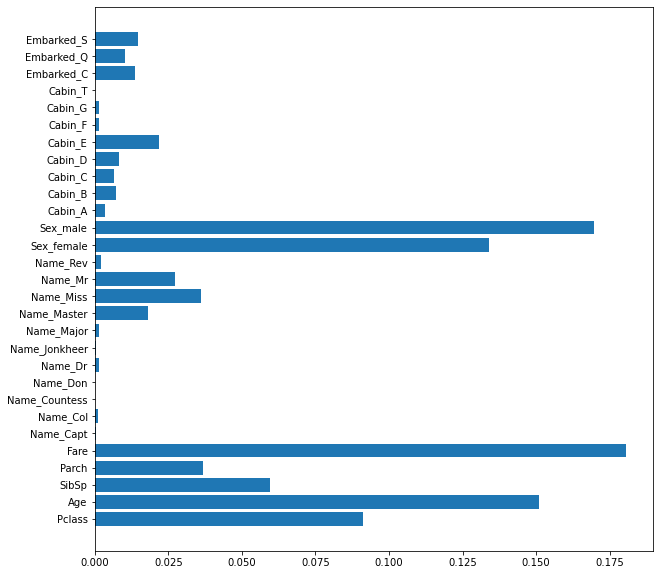

In [59]:
plt.figure(figsize=(10,10))
plt.barh(np.arange(len(rfc.feature_importances_)), rfc.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns);

---

# DecisionTreeClassifier + визуализация

In [96]:
dtc = DecisionTreeClassifier(max_depth = 5, min_samples_split = 2, random_state=42)
dtc.fit(X_train, y_train)
roc_auc_score(y_train, rfc.predict_proba(X_train)[:, 1])

0.9825999424791486

In [91]:
params = {'max_depth': [2,3,4,5], 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring = 'accuracy', verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy', verbose=1)

In [92]:
grid_search_cv.best_params_

{'max_depth': 5, 'min_samples_split': 2}

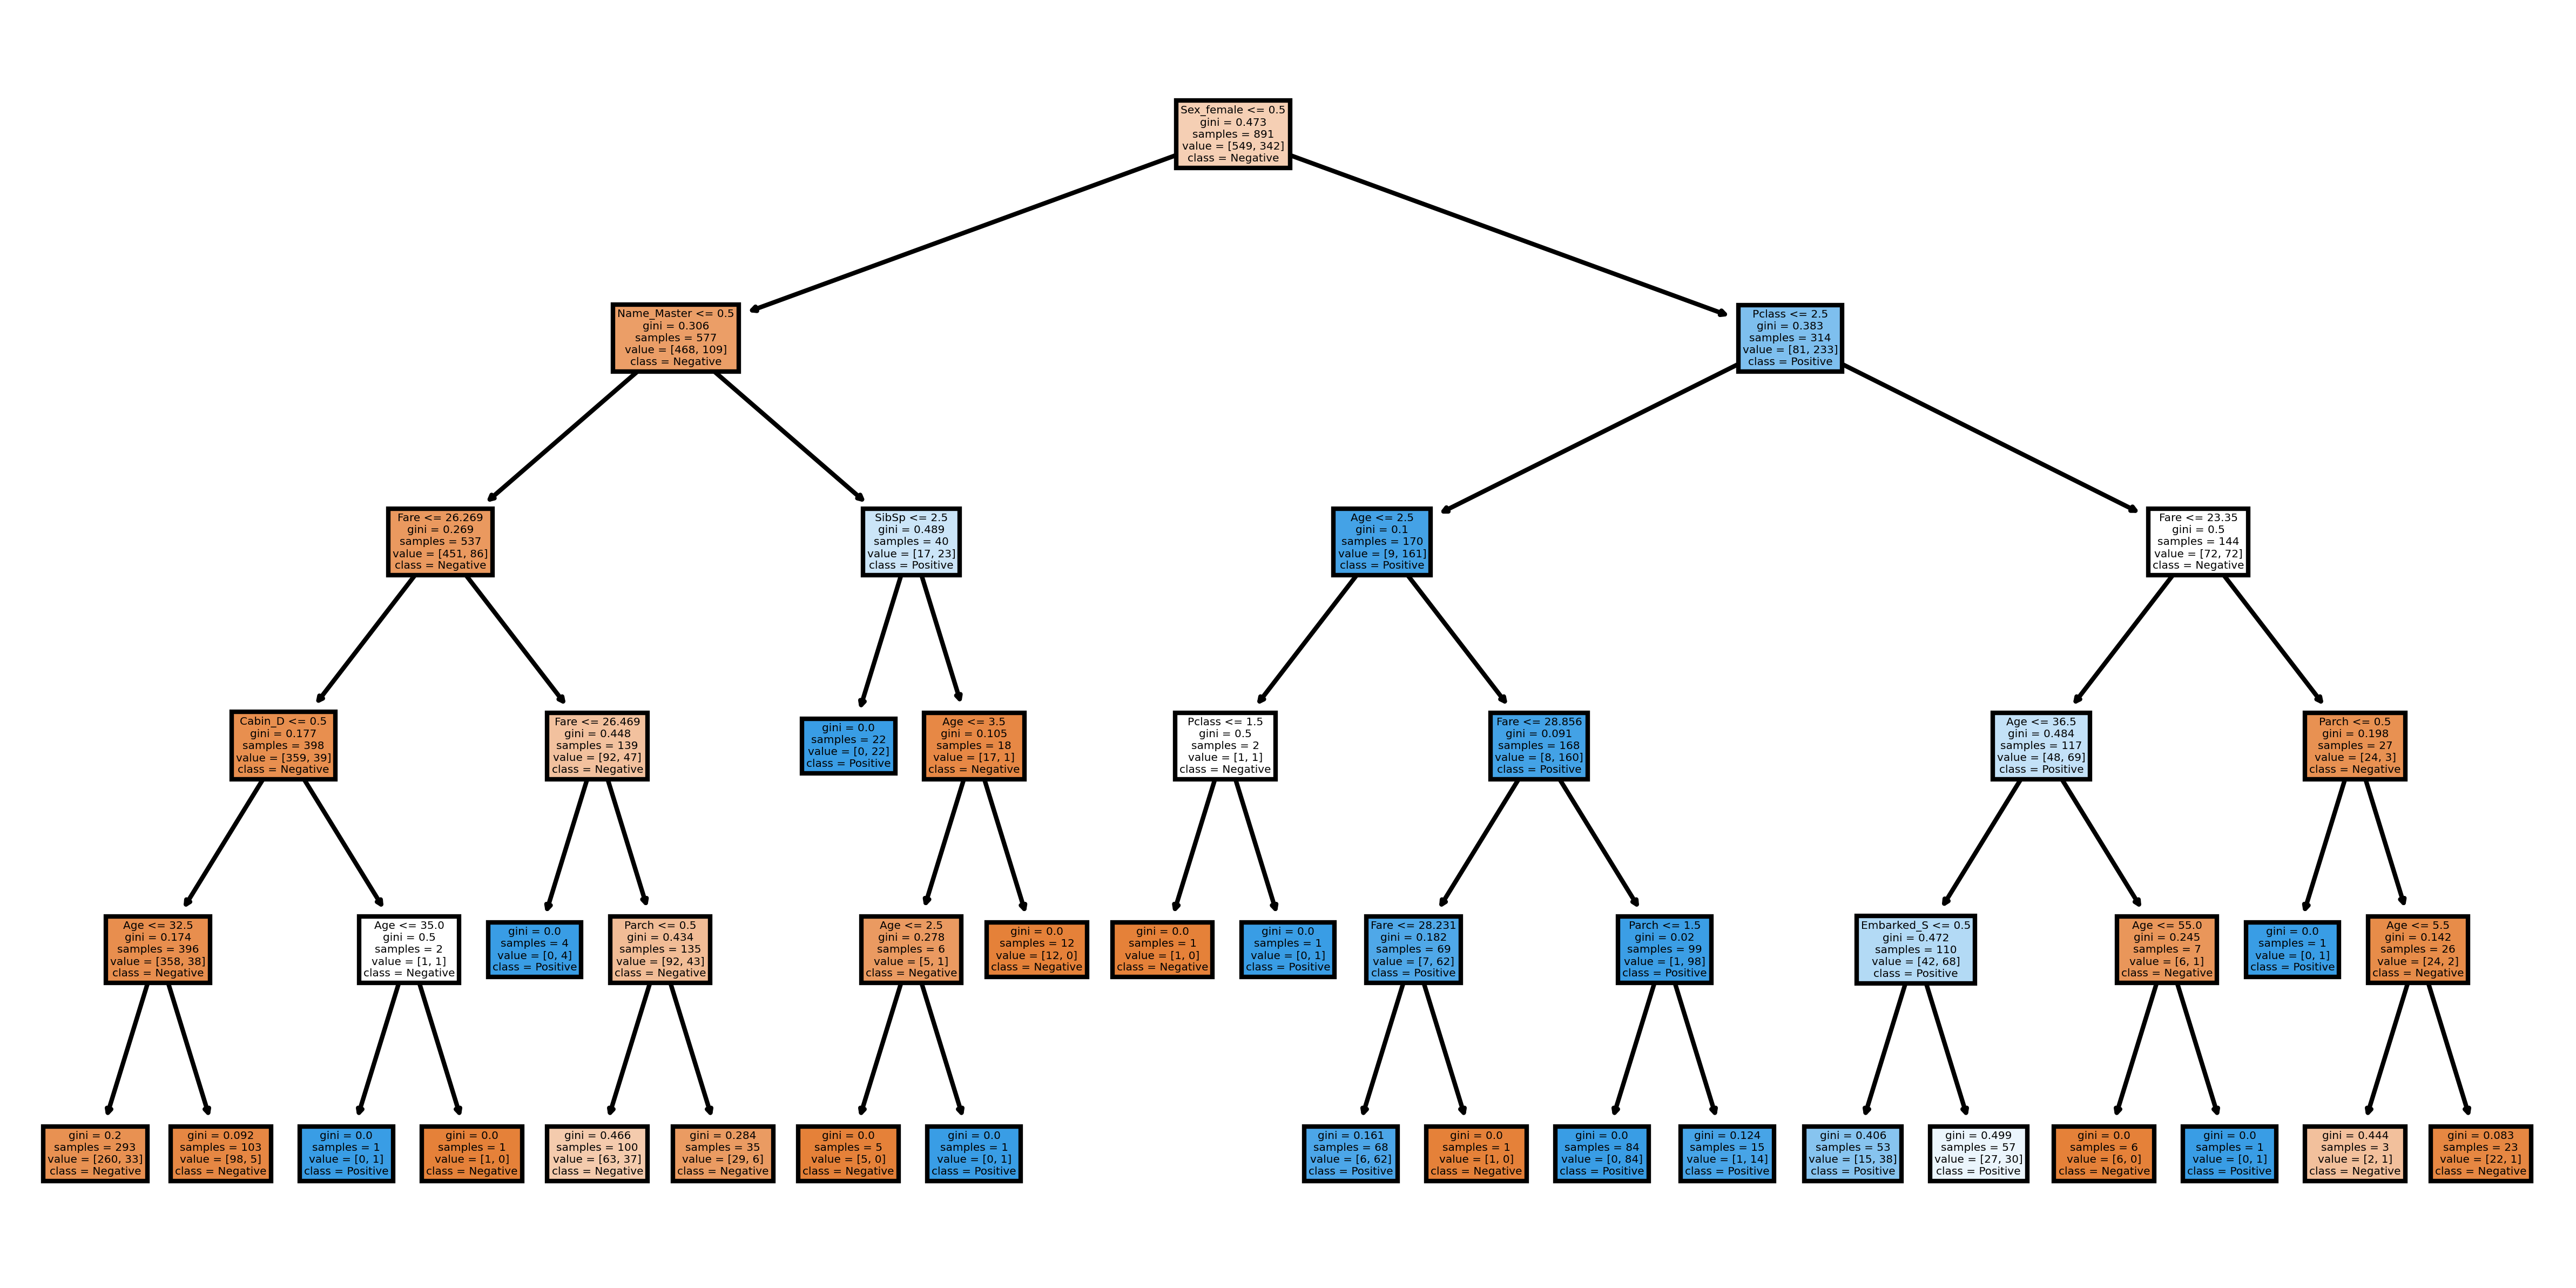

In [93]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5), dpi=600)
tree.plot_tree(dtc, feature_names=list(X_train),max_depth=10,
               class_names = ['Negative','Positive'],
               filled = True);